# 1. Load the Saved Correlation Matrices

In [10]:
import numpy as np
import os

# Directory where correlation matrices are saved
corr_dir = os.path.expanduser("~/correlation_matrices")

# Correlation types
correlation_types = ["correlation", "partial correlation", "tangent"]

# Dictionary to store loaded matrices
correlation_matrices = {}

# Load each correlation matrix file
for kind in correlation_types:
    file_path = os.path.join(corr_dir, f"{kind}_correlation_matrices.npz")
    data = np.load(file_path)
    correlation_matrices[kind] = data["matrices"]
    print(f"{kind}: {correlation_matrices[kind].shape}")


correlation: (155, 39, 39)
partial correlation: (155, 39, 39)
tangent: (155, 39, 39)


- 155 subjets 
- each with a 39x39 correlation matrix (between 39 regions)

# 2. Extract the Upper Triangle (excluding diagonal)

Goal:

- To convert each subject’s 39×39 correlation matrix into a flattened feature vector that only includes unique pairwise connections (no diagonal, no duplicates).



In [11]:
# Get indices for the upper triangle without diagonal

'''
For 39 nodes, that gives us 741 values (since matrix is symmetrical)
(since 39C2 = 741 unique region-to-region connections).
'''
n_nodes = correlation_matrices["correlation"].shape[1]

'''
This gets the indices for the upper triangle of a 39×39 matrix
excluding the diagonal.

For 39 nodes, that gives you 741 values (since matrix is symmetrical)
(since 39C2 = 741 unique region-to-region connections).

i.e. How many ways can we choose 2 regions out of 39 to form a connection?
'''
upper_idx = np.triu_indices(n_nodes, k=1)  # k=1 excludes diagonal # gets indices for upper triangle and k=1 excludes diagonal


# Function to extract upper triangles from a 3D matrix set
'''
Takes a set of correlation matrices 
For each subject, extracts just the upper triangle values
Returns an array of shape (155, 741) — one flattened feature vector per subject.
'''
def extract_upper_triangles(matrix_set):
    b = np.array([matrix[upper_idx] for matrix in matrix_set])
    print(b.shape)
    return b 
# Dictionary to store upper triangle features
'''
Loops over each correlation type
Applies the function to extract the features
Stores the results in upper_triangle_features
'''
upper_triangle_features = {}

for kind in correlation_types:
    upper_triangle_features[kind] = extract_upper_triangles(correlation_matrices[kind])
    print(f"{kind} features shape: {upper_triangle_features[kind].shape}")


(155, 741)
correlation features shape: (155, 741)
(155, 741)
partial correlation features shape: (155, 741)
(155, 741)
tangent features shape: (155, 741)


### 🧠 Why Upper Triangle?
We started with 155 subjects, each with a 39x39 matrix showing how brain regions are connected but this includes a lot of repeated values because the matrices are symmetric.

Also, the diagonal is always 1, which isn't helpful for learning (it's just a region connected to itself)

Now, for 39 brain regions, there are 741 unique pairs. So now each subject is described by 741 numbers (instead of a full 39×39 matrix).

- Shape (155, 741): 
   - 155 people
   - Each person is represented by 741 features (how strongly their brain regions connect)

# 3. Load Labels and Split the Data

Goal:
To load the class labels (child/adult), check the distribution, and split the data into training and testing sets for each type of correlation matrix.


In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import os

# Load class labels
label_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
labels = np.load(label_path)

# Confirm shape and class balance (shoes how many of each class we have)
print("Labels shape:", labels.shape)
print("Class distribution:", np.unique(labels, return_counts=True))

# empty dictionary to store Train-test split for each correlation type
split_data = {}

'''
For each correlation type:
- x =  741-feature vector per subject from the upper triangle
- y = class labels
- train_test_split(...) splits into:
  - 80% training, 20% testing
  - stratify=y ensures the same class ratio is maintained in both sets
'''
for kind in correlation_types:  # ["correlation", "partial correlation", "tangent"]
    X = upper_triangle_features[kind]
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    split_data[kind] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test
    }

    print(f"{kind} ➤ Train: {X_train.shape}, Test: {X_test.shape}")


Labels shape: (155,)
Class distribution: (array([0, 1]), array([122,  33]))
correlation ➤ Train: (124, 741), Test: (31, 741)
partial correlation ➤ Train: (124, 741), Test: (31, 741)
tangent ➤ Train: (124, 741), Test: (31, 741)


- 155 subjects 
- 122 children (0) and 33 adults (1)
- 124 train samples
- 31 test samples
- 741 features per sample (from upper triangle)

# 4. Logistic Regression Training + Evaluation

#tp,fn,fp,tn


--- CORRELATION ---
Accuracy: 0.8387

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.67      0.57      0.62         7

    accuracy                           0.84        31
   macro avg       0.77      0.74      0.76        31
weighted avg       0.83      0.84      0.83        31



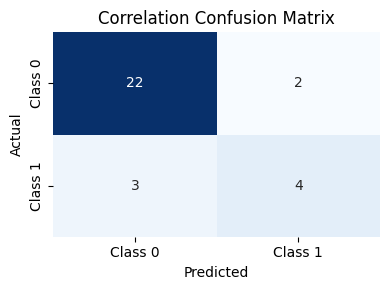


--- PARTIAL CORRELATION ---
Accuracy: 0.8710

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.80      0.57      0.67         7

    accuracy                           0.87        31
   macro avg       0.84      0.76      0.79        31
weighted avg       0.87      0.87      0.86        31



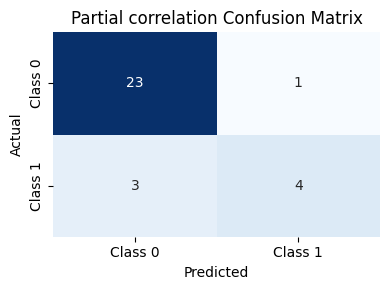


--- TANGENT ---
Accuracy: 0.8710

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.43      0.60         7

    accuracy                           0.87        31
   macro avg       0.93      0.71      0.76        31
weighted avg       0.89      0.87      0.85        31



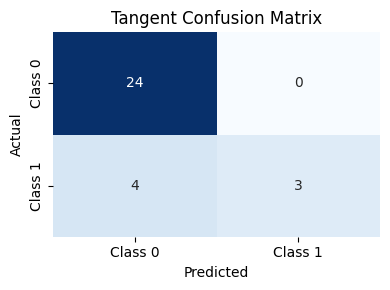

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



for kind in correlation_types: #loops over each correlation type
    print(f"\n--- {kind.upper()} ---")
    
    #load the train/test features and labels for the current correlation type
    X_train = split_data[kind]["X_train"] 
    X_test = split_data[kind]["X_test"]
    y_train = split_data[kind]["y_train"]
    y_test = split_data[kind]["y_test"]

    #logistic regression model
    #class_weight = 'balanced' automatically adjusts for class imbalance
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)

    #make predictions and evaluate
    y_pred = model.predict(X_test)
    
    #calculate accuracy and print accuracy, precision, recall and F1 score for each class
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred) #confusion matrix

    # Plot the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Class 0", "Class 1"],
                yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{kind.capitalize()} Confusion Matrix")
    plt.tight_layout()
    plt.show()


# 5. Logistic Regression + SMOTE

SMOTE - Synthetic Minority Oversampling Technique:

- method used to balance imbalanced datasets
- especially useful in binary classification problems when one class has way fewer samples than the other.


--- CORRELATION + SMOTE ---
Accuracy: 0.8710

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        24
           1       0.80      0.57      0.67         7

    accuracy                           0.87        31
   macro avg       0.84      0.76      0.79        31
weighted avg       0.87      0.87      0.86        31



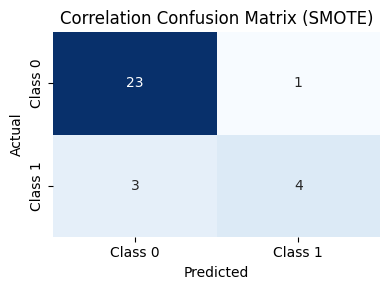


--- PARTIAL CORRELATION + SMOTE ---
Accuracy: 0.8387

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.75      0.43      0.55         7

    accuracy                           0.84        31
   macro avg       0.80      0.69      0.72        31
weighted avg       0.83      0.84      0.82        31



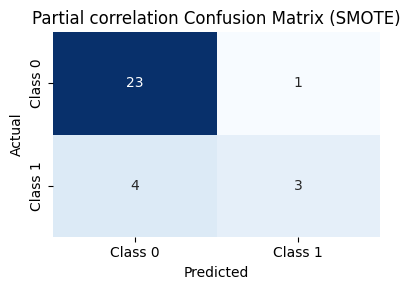


--- TANGENT + SMOTE ---
Accuracy: 0.8710

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       1.00      0.43      0.60         7

    accuracy                           0.87        31
   macro avg       0.93      0.71      0.76        31
weighted avg       0.89      0.87      0.85        31



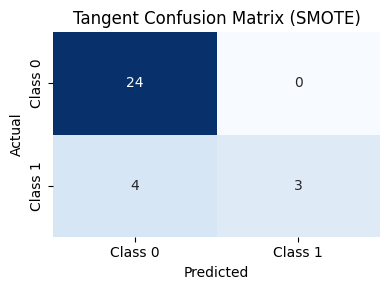

In [14]:
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

for kind in correlation_types: #loops over each correlation type
    print(f"\n--- {kind.upper()} + SMOTE ---")
    
    #load the train/test features and labels for the current correlation type
    X_train = split_data[kind]["X_train"]
    X_test = split_data[kind]["X_test"]
    y_train = split_data[kind]["y_train"]
    y_test = split_data[kind]["y_test"]

    # Apply SMOTE to the training data to generate synthetic minority class samples and return a balanced training set
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    # Train logistic regression on resampled data
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_resampled, y_resampled)

    # Predict and evaluate on the original test set(without SMOTE)
    y_pred = model.predict(X_test)
    
    #print overall accuracy, precision, recall, and f1
    acc = accuracy_score(y_test, y_pred) 
    print(f"Accuracy: {acc:.4f}") 
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Class 0", "Class 1"],
                yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{kind.capitalize()} Confusion Matrix (SMOTE)")
    plt.tight_layout()
    plt.show()
